#  Perfect_Synthetic

## Imports

In [1]:
from datetime import datetime
import pandas_datareader as pdr
import yfinance as yf
from copy import deepcopy
import math

# Imports
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.models import Prediction
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI
from tigramite.causal_effects import CausalEffects

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gpdc import GPDC

from collections import defaultdict, OrderedDict
from itertools import combinations, permutations

from statsmodels.tsa.arima.model import ARIMA
from IPython.display import display, Markdown


## Data

In [2]:
# Synthetic Data Generation
title = "Synthetic Time series"
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$', r'$X^4$']
true_link_coeffs = {0: [(0, -1)], 1: [(1, -1), (0, -1)], 2: [(2, -1), (0, -2)], 3: [(3, -1)], 4: [(4, -1), (3, 0)]}

np.random.seed(14)     # Fix random seed
lin_f = lambda x: x
causal_rules = {0: [((0, -1), 0.7, lin_f)],
                1: [((1, -1), 0.8, lin_f), ((0, -1), 0.3, lin_f)],
                2: [((2, -1), 0.5, lin_f), ((0, -2), -0.5, lin_f)],
                3: [((3, -1), 0., lin_f)], #, ((4, -1), 0.4, lin_f)],
                4: [((4, -1), 0., lin_f), ((3, 0), 0.5, lin_f)], #, ((3, -1), 0.3, lin_f)],
               }
T = 5000     # time series length
# Make some noise with different variance, alternatively just  noises=None
noises = np.array([(1. + 0.2*float(j))*np.random.randn((T + int(math.floor(0.2*T)))) 
                   for j in range(len(causal_rules))]).T
data, _ = toys.structural_causal_process(causal_rules, T=T, noises=noises, seed=14)
df= pd.DataFrame(data)
print(df)

             0         1         2         3         4
0     2.451507  0.428924 -1.822130  0.007697  1.648537
1     2.484816  2.937346 -3.498601  0.424070 -4.269078
2     3.751108  2.190531 -2.432084  0.013493  1.315353
3     2.753795  2.566917 -2.173746  0.322877  2.672673
4     2.010883  5.815972 -0.936668  1.000223  0.109160
...        ...       ...       ...       ...       ...
4995  1.239437  0.762260 -0.487476 -1.685248 -1.892629
4996  0.503089 -0.813097  1.574070  0.742365  0.769210
4997  1.971811  1.108347 -0.800308 -0.872053 -1.967528
4998  1.920608  1.199177 -1.215795  0.332776 -1.597023
4999  1.342063  1.314400 -1.197314  0.132880 -0.157255

[5000 rows x 5 columns]


## Data Processing

Synthetic Time series


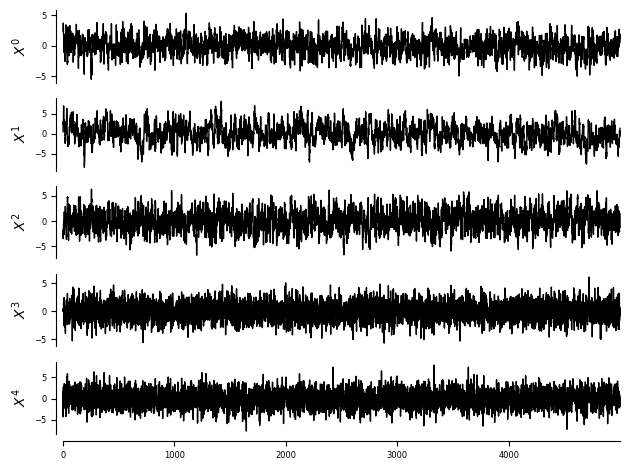

In [3]:
# Data Processing
data = df.values
N = data.shape[1]
T = len(data)
datatime = np.arange(T)
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe)
print(title)
plt.show()

## Choose Parameters

In [7]:
#### Choose training and temporal parameters ####
train_size = 4500
prediction_size = 1
step_size = 1
num_iterations = 30

#### Choose sliding window PCMCI parameters #####
window_step = 720
window_length = 720

# method='run_pcmci'
method='run_pcmciplus'

cond_ind_test = ParCorr(significance='analytic')
# cond_ind_test = RobustParCorr(verbosity=0)
# cond_ind_test = ParCorrWLS(significance='analytic')
# cond_ind_test = GPDC(significance='analytic')
# cond_ind_test = CMIknn(significance="fixed_thres")
# cond_ind_test = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks', sig_samples=50)

pc_alpha = 0.5 #(smaller alpha -> less links, α = 1 -> MCI test becomes a FullCI test)

## Run Causal Discovery

run_pcmciplus
0.5
Sliding Window Causal Discovery Results


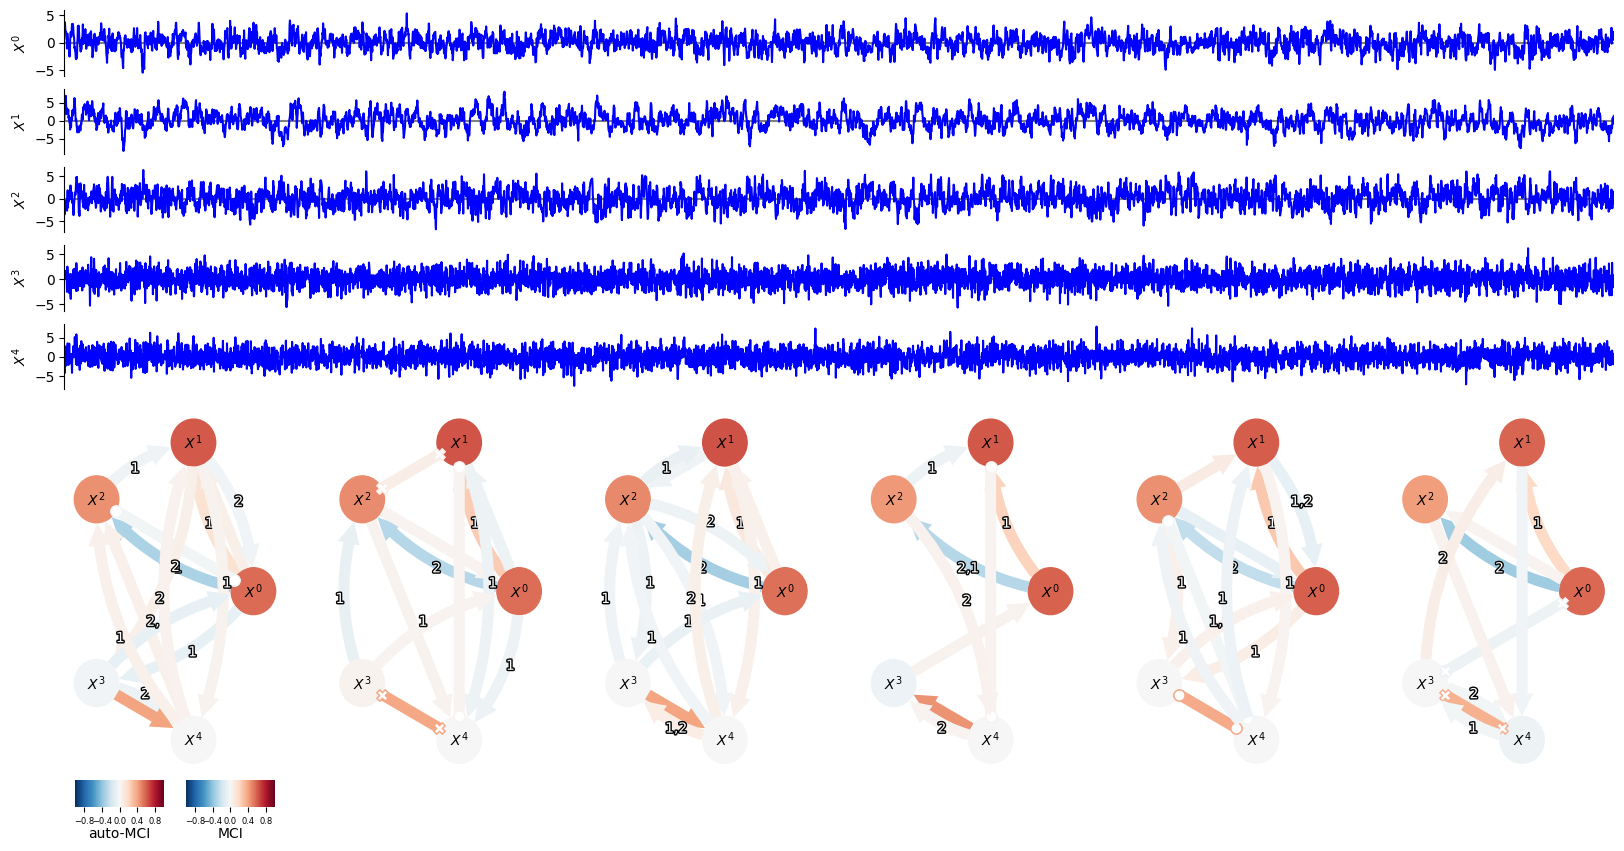

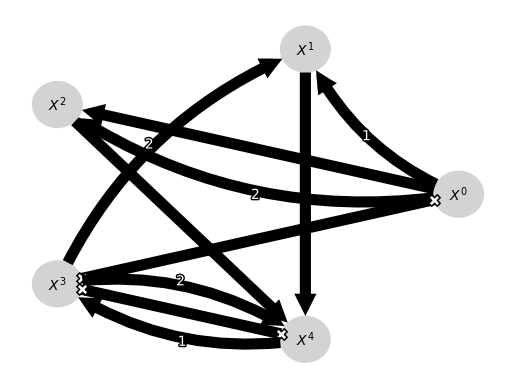

Most Recent Causal Graph
______________________________________________________________________________
Most Recent Time Series Graph


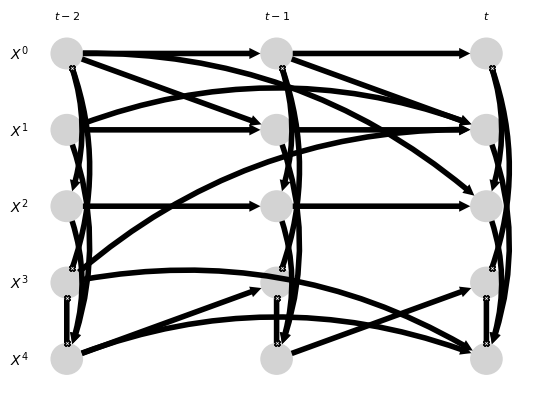

Links Coefficients: {0: [(0, -1)], 1: [(0, -1), (1, -1), (1, -2), (3, -2)], 2: [(0, 0), (0, -2), (2, -1)], 3: [(4, -1)], 4: [(1, 0), (2, 0), (3, -2), (4, -2)]}
Structural Hamming Distance: 11


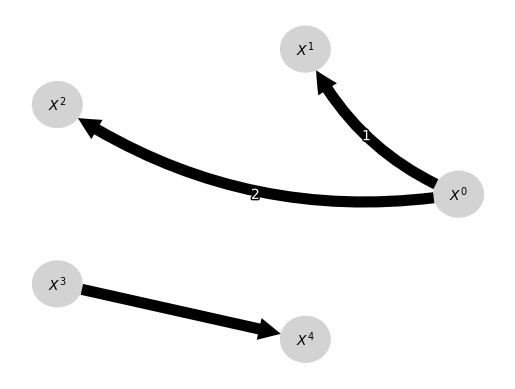

In [8]:
print(method)
print(cond_ind_test)
print(pc_alpha)

#### Other parameters to be set ####
tau_min = 0
tau_max = 2
method_args = {'tau_min':tau_min, 'tau_max':tau_max, 'pc_alpha':pc_alpha}
conf_lev = 0.95


start_index = 0
end_index = start_index + train_size
train_indices = list(datatime[start_index : end_index])
test_indices = list(datatime[end_index + tau_max : end_index + tau_max + prediction_size])
train_df = df.iloc[start_index : end_index]
train_data = train_df.values
train_pp = pp.DataFrame(train_data, var_names=var_names)

####################### Run PCMCI to get links_coeffs ##########################
pcmci = PCMCI(dataframe=train_pp,
              cond_ind_test=cond_ind_test,
              verbosity=0)

results = pcmci.run_sliding_window_of(method=method, 
                                      method_args=method_args, 
                                      window_step=window_step,
                                      window_length=window_length,
                                      conf_lev=conf_lev)

###################### Plot Sliding window causal graphs ##########################
graphs = results['window_results']['graph']
val_matrices = results['window_results']['val_matrix']
n_windows = len(graphs)

print("Sliding Window Causal Discovery Results")
mosaic = [['data %s' %j for i in range(n_windows)] for j in range(N)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_windows)])
#  print(mosaic)
fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    color = 'blue'
    ax.plot(datatime, data[:,j], color=color)
#     axs['data %s' %j].axis('off') # xaxis.set_ticklabels([])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])

for w in range(n_windows):
    if w == 0: show_colorbar=True
    else: show_colorbar = False
    tp.plot_graph(graphs[w], val_matrix=val_matrices[w], show_colorbar=show_colorbar, var_names=var_names,
                  fig_ax=(fig, axs['graph %s' %w]))

##################### Get link_coeffs of the LAST causal graph ##################

G = len(results['window_results']["graph"]) - 1
last_graph = results['window_results']["graph"][G]
clean = lambda l: l.replace('o-o','').replace('x-x','')
vfunc = np.vectorize(clean)
graph_cleaned = vfunc(last_graph)
links_coeffs = toys.dag_to_links(graph_cleaned)

##### Plot most recent causal graph #######
tp.plot_graph(last_graph, var_names=var_names)
plt.show()
print("Most Recent Causal Graph")
print("______________________________________________________________________________")
print("Most Recent Time Series Graph")
tp.plot_time_series_graph(last_graph, var_names=var_names)
plt.show()
print(f"Links Coefficients: {links_coeffs}")

# Calculate and print the Structural Hamming Distance
def structural_hamming_distance(graph1, graph2):
    distance = 0
    all_vars = set(graph1.keys()).union(graph2.keys())
    for var in all_vars:
        links1 = set(graph1.get(var, []))
        links2 = set(graph2.get(var, []))
        distance += len(links1.symmetric_difference(links2))
    return distance

hamming_distance = structural_hamming_distance(true_link_coeffs, links_coeffs)
print(f"Structural Hamming Distance: {hamming_distance}")
true_causal_graph = toys.links_to_graph(true_link_coeffs, tau_max=2)
tp.plot_graph(true_causal_graph, var_names=var_names)
plt.show()


## Run Causal Forecasting

In [9]:
#### Choose Prediction parameters (relevant only for the forecasting phase) ####
prediction_model = sklearn.linear_model.LinearRegression()
# prediction_model = sklearn.gaussian_process.GaussianProcessRegressor()
# prediction_model = sklearn.neighbors.KNeighborsRegressor()

LinearRegression()


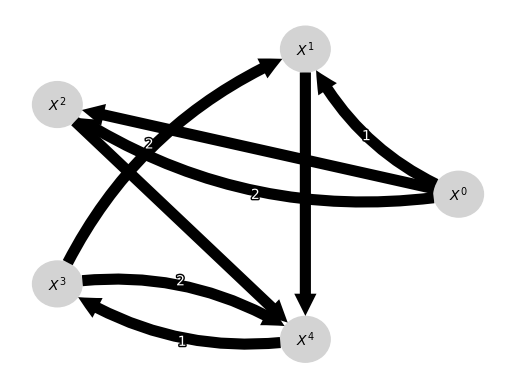

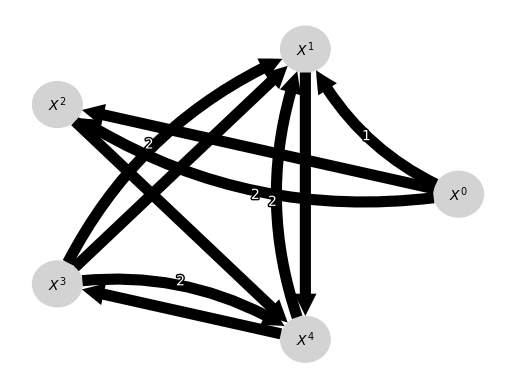

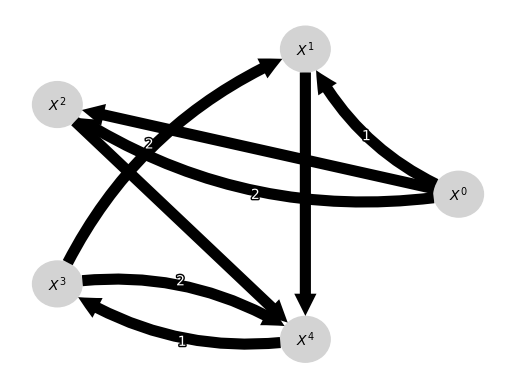

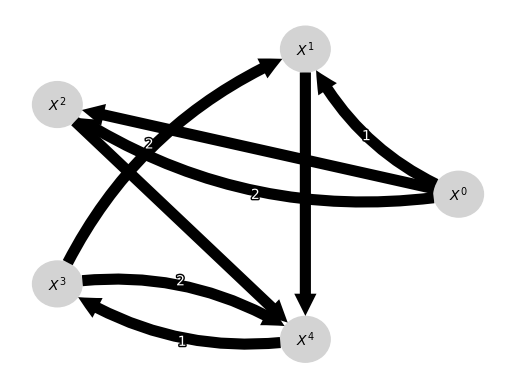

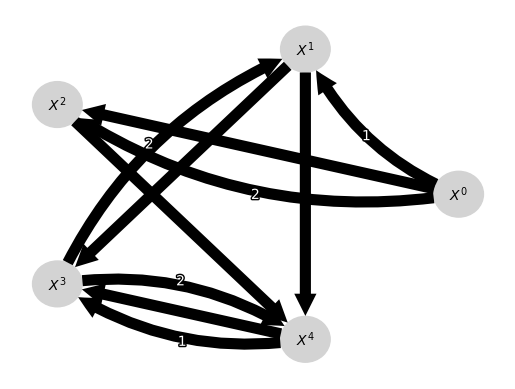

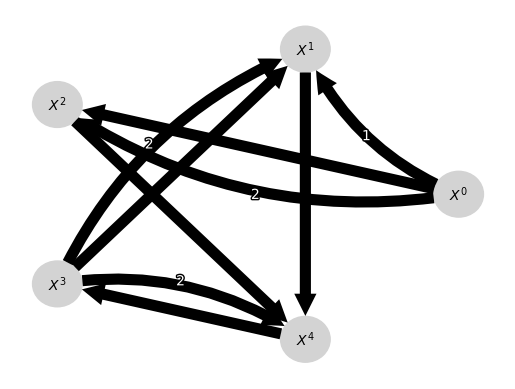

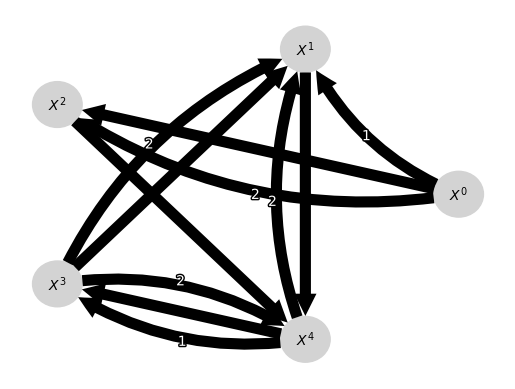

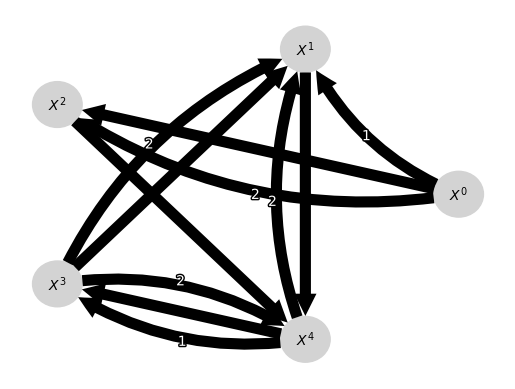

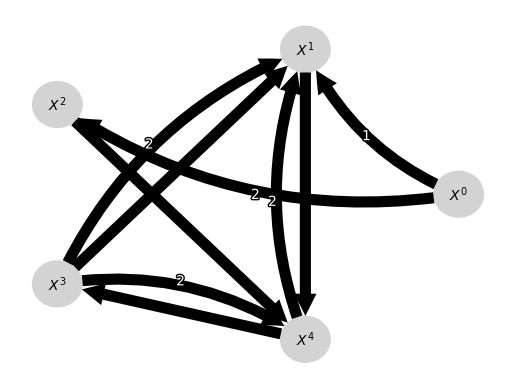

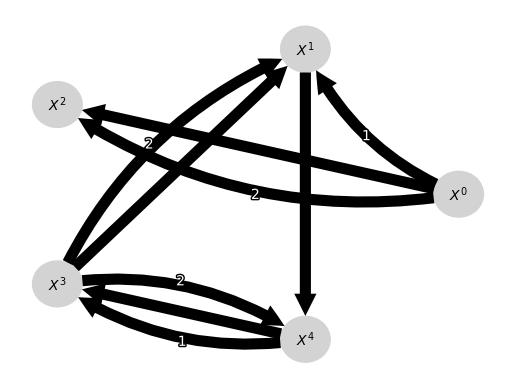

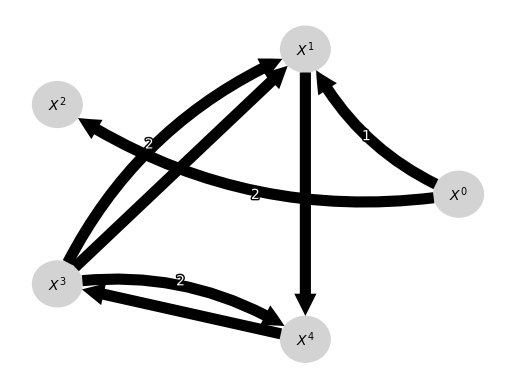

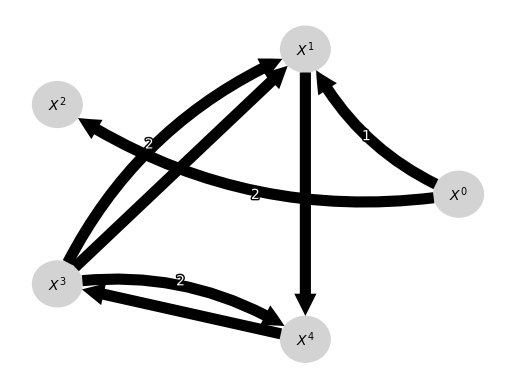

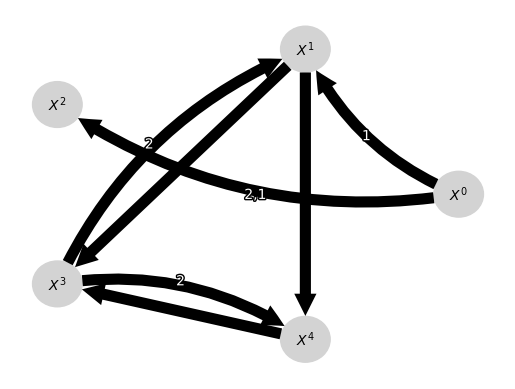

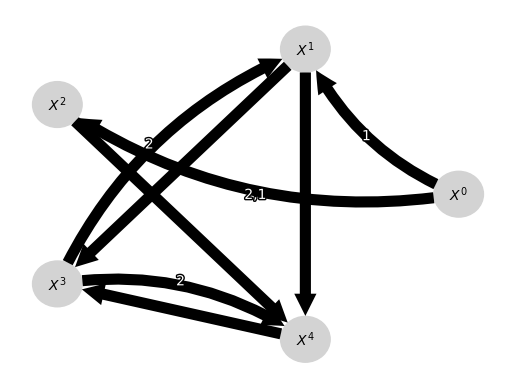

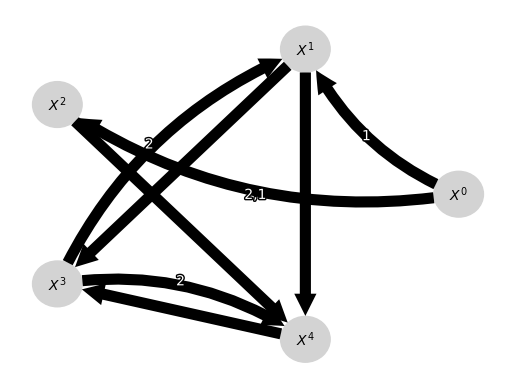

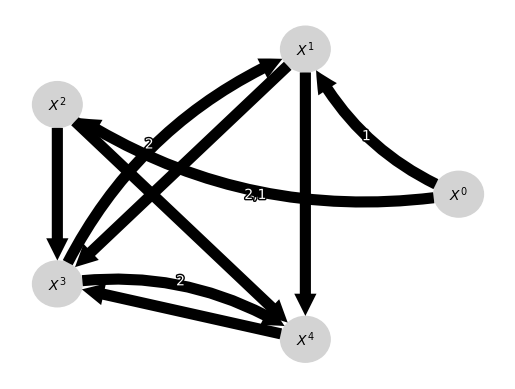

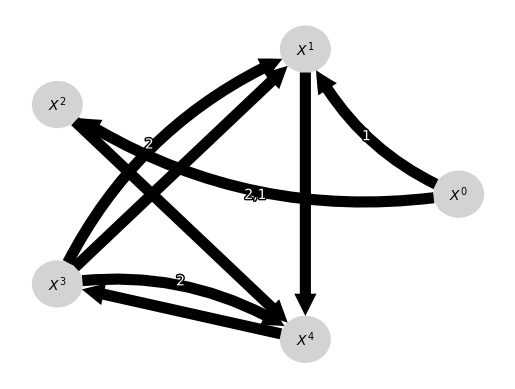

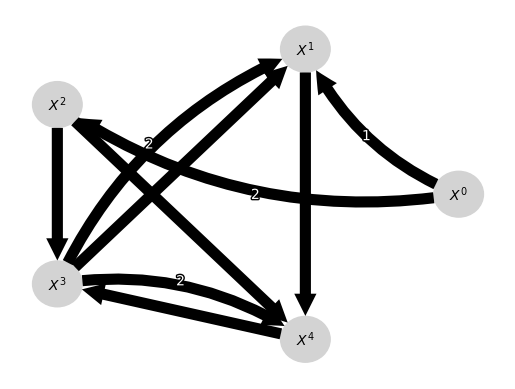

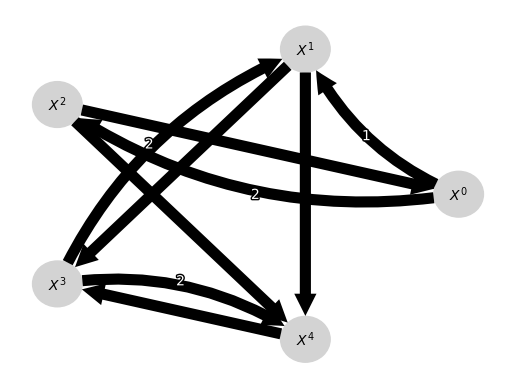

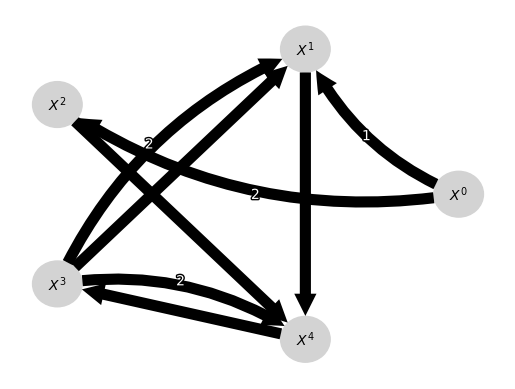

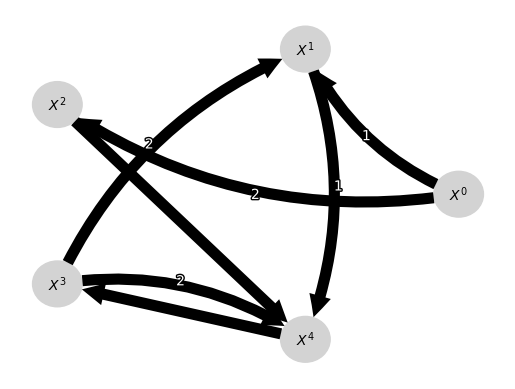

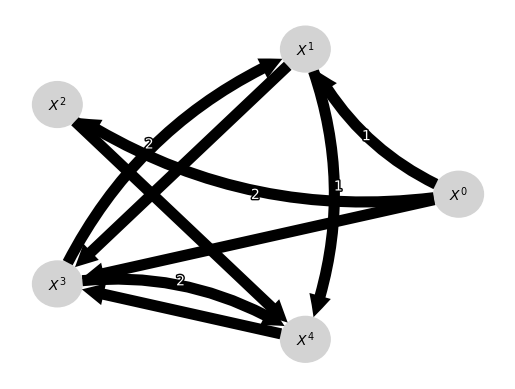

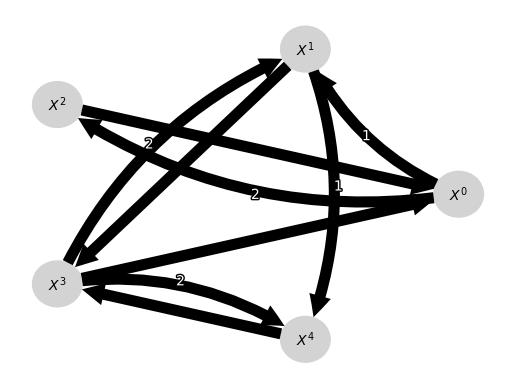

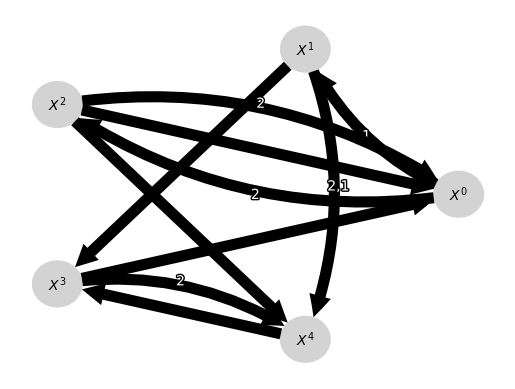

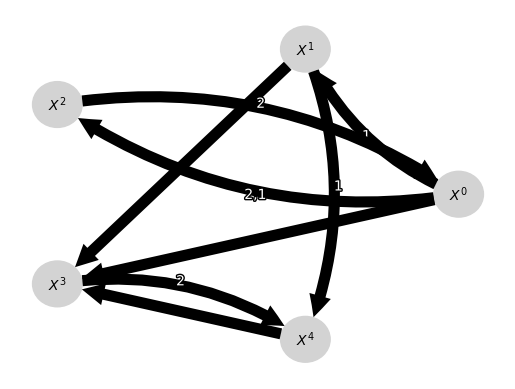

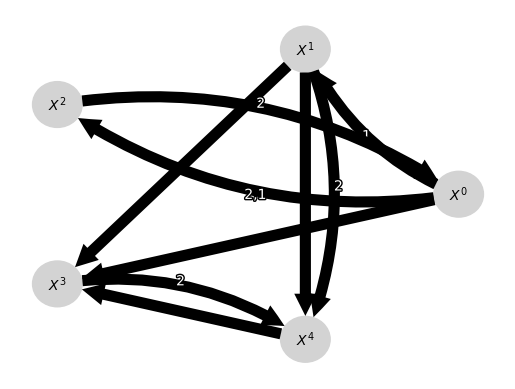

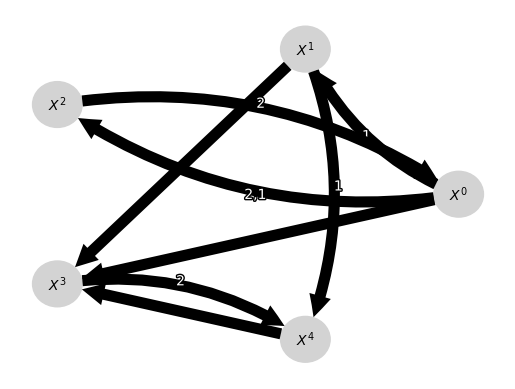

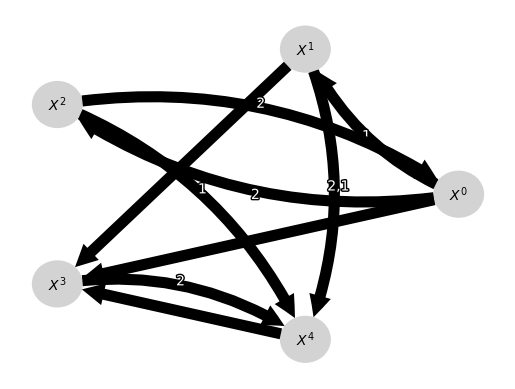

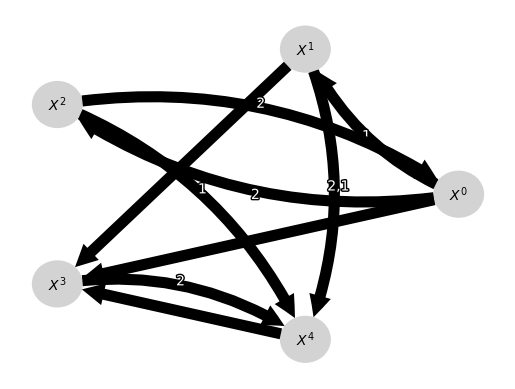

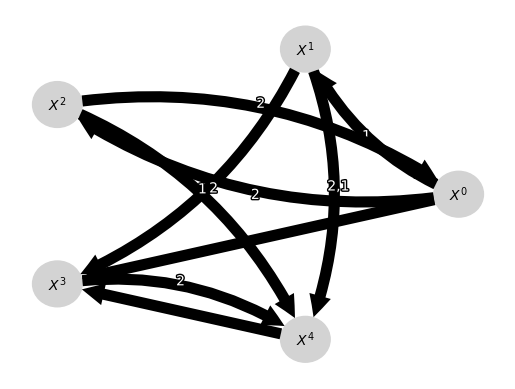

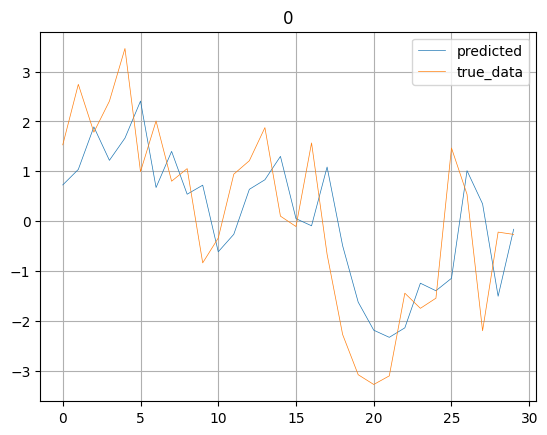

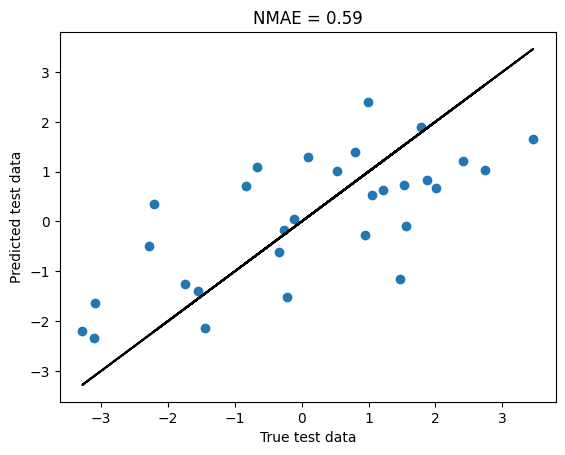

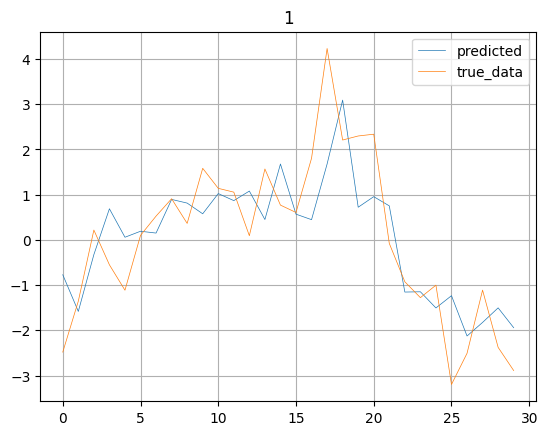

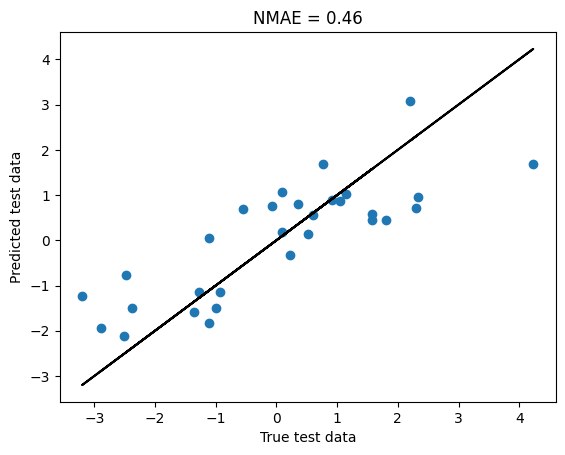

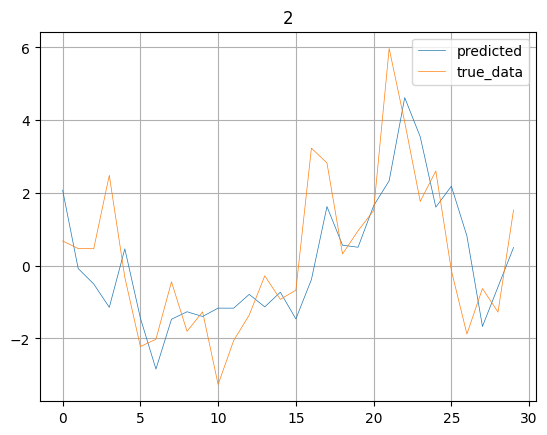

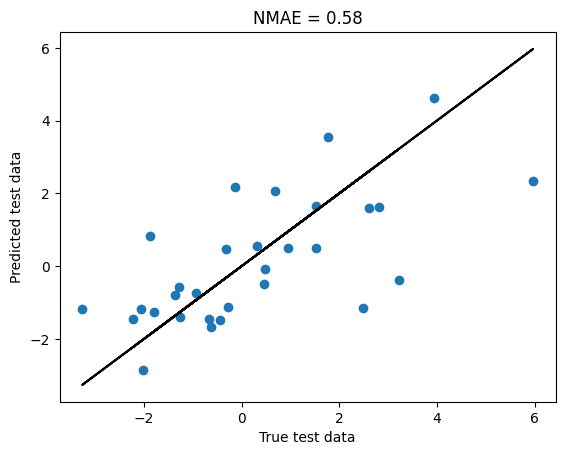

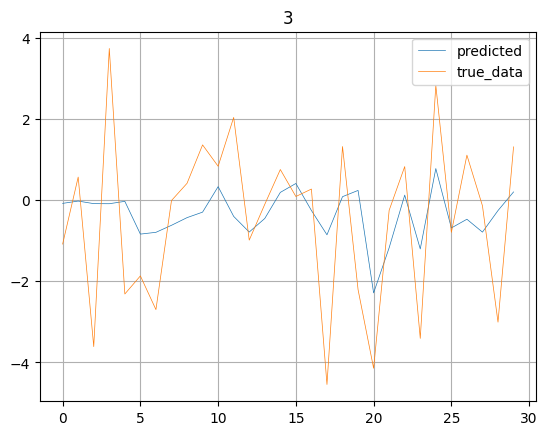

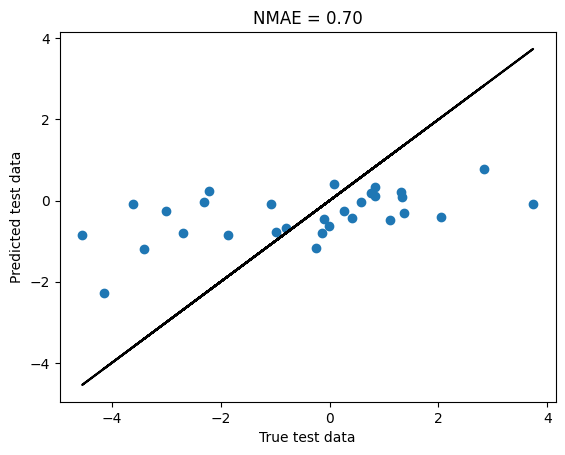

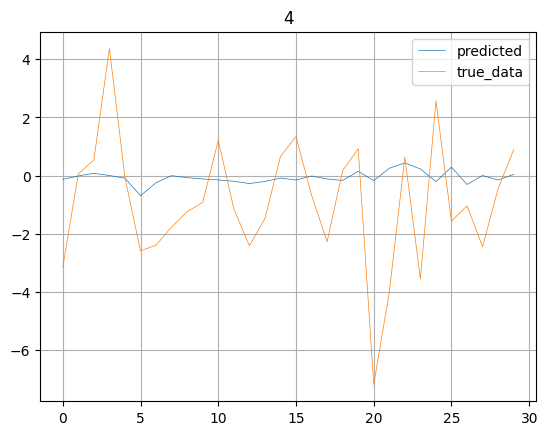

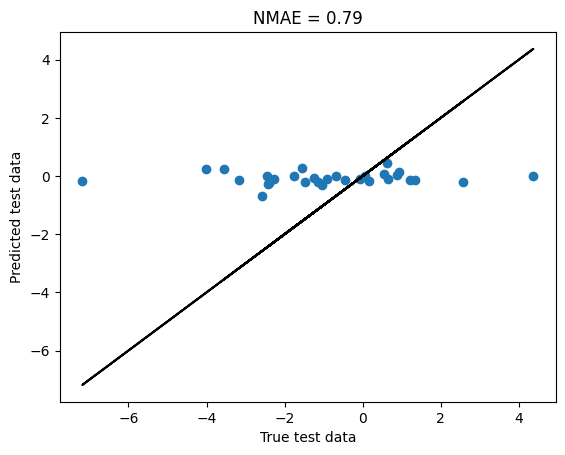

Average NMAE: 0.6232444


In [10]:
print(cond_ind_test)
print(prediction_model)

#### Other parameters to be set ####
tau_min = 0
tau_max = 2
method_args = {'tau_min':tau_min, 'tau_max':tau_max, 'pc_alpha':pc_alpha}
conf_lev = 0.95
data_transform = None
# data_transform = sklearn.preprocessing.StandardScaler()
steps_ahead = 1
pred_cond_ind_test = ParCorr(significance='analytic') 
# Note: Because we do not use the results of the pcmci wrapper included in the prediction class but we run our own 
# causal discovery, we set cond_ind_test of the prediction equal to the less computational test statistic (ParCorr).

#### Prepare Training and Test data ####
predicted_data = []
actual_data = []

#### Start Iteration ####
for i in range(num_iterations):
    predicted_values = []
    actual_values = []
    start_index = i * step_size
    end_index = start_index + train_size
    train_indices = list(datatime[start_index : end_index])
    test_indices = list(datatime[end_index + tau_max : end_index + tau_max + prediction_size])
    train_df = df.iloc[start_index : end_index]
    train_data = train_df.values
    train_pp = pp.DataFrame(train_data, var_names=var_names)
    
#### Run PCMCI to get links_coeffs ####
    pcmci = PCMCI(dataframe=train_pp,
                  cond_ind_test=cond_ind_test,
                  verbosity=0)
    
    results = pcmci.run_sliding_window_of(method=method, 
                                          method_args=method_args, 
                                          window_step=window_step,
                                          window_length=window_length,
                                          conf_lev=conf_lev)
    
#### Plot Sliding window causal graphs ####
    graphs = results['window_results']['graph']
    val_matrices = results['window_results']['val_matrix']
    n_windows = len(graphs)
    
#### Get and plot link_coeffs of the most recent causal graph ####
    G = len(results['window_results']["graph"]) - 1
    last_graph = results['window_results']["graph"][G]
    clean = lambda l: l.replace('o-o','').replace('x-x','')
    vfunc = np.vectorize(clean)
    graph_cleaned = vfunc(last_graph)
    links_coeffs = toys.dag_to_links(graph_cleaned)
    tp.plot_graph(graph_cleaned, var_names=var_names)
    plt.show()
    
#### Start Prediction ####
    nmae_values = []
    predicted_values = []
    actual_values = []
    train_pred_indices = train_indices[-window_length:]
    predictable_variable = list(range(N))
    # predictable_variable = [key for key, value in links_coeffs.items() if value]
    # Notes: this takes only the predictable variables, but is not applicable to iter approach. #

#### Run prediction function over each variable ####
    for variable in predictable_variable:
        
        # Define prediction function
        pred = Prediction(dataframe=dataframe,
                          # train_indices=train_indices,
                          train_indices=train_pred_indices,
                          test_indices=test_indices,
                          cond_ind_test=pred_cond_ind_test,
                          prediction_model=prediction_model,
                          data_transform=data_transform,
                          verbosity=0)
        
        # Fit prediction using links_coeffs as target_predictors for the chosen target variable
        pred.fit(target_predictors=links_coeffs, 
                 selected_targets=[variable],
                 tau_max=tau_max)
    
        # Get the predicted and true data
        predicted = pred.predict(target=variable)
        true_data = pred.get_test_array(j=variable)[0]
        predicted_values.append(predicted)
        actual_values.append(true_data)
    
    predicted_data.append(predicted_values)     
    actual_data.append(actual_values)
    
predicted_df = pd.DataFrame(predicted_data)
actual_df = pd.DataFrame(actual_data)

#### Calculate and plot accuracy results ####
nmae_values = []
for variable in predictable_variable:
    plt.plot(predicted_df[variable], label='predicted', linewidth=0.5)
    plt.plot(actual_df[variable], label='true_data', linewidth=0.5)
    plt.title(f'{variable}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot NMAE
    nmae = np.abs(actual_df[variable] - predicted_df[variable]).mean() / actual_df[variable].std()
    nmae_values.append(nmae)
    plt.scatter(actual_df[variable], predicted_df[variable])
    plt.plot(actual_df[variable], actual_df[variable], 'k-')
    plt.title(r"NMAE = %.2f" % (nmae))
    plt.xlabel('True test data')
    plt.ylabel('Predicted test data')
    plt.show()

average_nmae = np.mean(nmae_values)
print("Average NMAE:", average_nmae)